# CME 193 — Homework 1: Ordinary Least Squares and Regularization with Ridge Regression

- **Semester**: Autumn 2025
- **Instructor**: Tianyu Du (`tianyudu@stanford.edu`)

Please install the following packages before running the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Homework Instructions

### Learning objectives
- Implement closed-form OLS using efficient NumPy operations (matrix multiply, solve).
- Implement predictions for linear models and compute RMSE and $R^2$.
- Implement ridge regression with an unpenalized intercept and study the effect of $\lambda$.
- Practice basic object-oriented design in Python (fit/predict API).
- Interpret plots and metrics to reason about bias–variance and generalization.

### Prerequisites
- Python and NumPy basics (arrays, broadcasting, `@`, `.T`, `np.linalg`)
- Linear algebra: transpose, dot products, normal equations, we have covered this in the lecture.

### What you need to do
- Fill in the TODOs:
  - `OLSClosedForm.fit` and `predict`
  - `RMSE` and `R2`
  - `RidgeClosedForm.fit` and `predict`
- Run the provided cells to generate data, fit models, and create plots.
- Answer the short discussion prompts after each part (a few sentences each).

### Dataset used
We provide a synthetic data generator that adds an intercept (first column of ones). Do not add a second intercept.

### Deliverables
- A single executed notebook (`.ipynb`) with:
  - Working implementations for OLS, RMSE/R², and ridge
  - Plots produced by the notebook
  - Brief written answers to the prompts (Parts 1–3)

### Grading rubric (guideline)
- 70% correctness of implementations (API, numerics, shapes)
- 30% clarity of explanations/interpretations

### Submitting this homework
Rename your notebook to `CME193_HW1_OLS_<YOUR_NAME_AND_STANFORD_EMAIL>.ipynb` and submit to **Canvas**. Please keep outputs visible (do not clear them) so we can review your results.

### Expected time to complete this homework
About 1 hour. If you get stuck, email me or come to office hours.

### Deadline
Due **10/31/2025 (Friday)**. You may use late days. For emergencies (medical, family, etc.), email me for a possible extension. See the course website for policy details.

### Academic integrity
Follow the course academic integrity policy. Collaboration is allowed; list collaborators. Write your own code.

### AI usage
You may consult AI tools (e.g., ChatGPT) for guidance, but you must write and understand your own code.


## Helper — Synthetic data generator

Generate synthetic linear regression data with $P$ features and $N$ samples. Automatically adds an intercept column to $X$ (first column of ones), and includes the intercept in $\beta_\text{true}[0]$.

Mathematical description:
- Sample coefficients $\beta_\text{true} \in \mathbb{R}^{P}$ i.i.d. from $\mathrm{Unif}(0, 10)$ (intercept at index 0).
- Sample raw features $Z \in \mathbb{R}^{N \times (P-1)}$ with entries i.i.d. $\mathcal{N}(0,1)$, and form $X = [\mathbf{1}, Z] \in \mathbb{R}^{N \times P}$.
- Compute the noiseless response $y = X\,\beta_\text{true}$.
- Split indices into training and testing sets (shuffle by default), with test fraction $\text{test\_size}$.
- Return $(X_{\text{train}}, X_{\text{test}}, y_{\text{train}}, y_{\text{test}}, \beta_\text{true})$.

Parameters:
- $P$: number of non-intercept features.
- $N$: number of samples.
- $\text{test\_size}$: fraction of samples in the test set (default 0.2).
- `shuffle`: whether to shuffle before split (default True).
- `rng`: optional NumPy generator for reproducibility.


In [2]:
def generate_synthetic_linear_data(num_features: int | None = None, num_samples: int | None = None, *,
                                   p: int | None = None, n: int | None = None,
                                   test_size: float = 0.2, shuffle: bool = True,
                                   noise_std: float = 0.5, noise: float | None = None,
                                   rng: np.random.Generator | None = None, seed: int | None = None):
    """
    Generate synthetic linear regression data and split into train/test sets.

    Adds a column of ones as the first column of X (intercept) and returns the
    ground-truth coefficients used to synthesize y.

    Parameters
    ----------
    num_features, p : int, optional
        Number of non-intercept features P. Provide either `num_features` or `p`.
    num_samples, n : int, optional
        Number of samples N. Provide either `num_samples` or `n`.
    test_size : float, default=0.2
        Fraction of samples assigned to the test set (0 < test_size < 1).
    shuffle : bool, default=True
        Whether to shuffle before splitting.
    noise_std, noise : float, optional
        Standard deviation of i.i.d. Gaussian noise added to y.
        If both are provided, `noise` takes precedence. Use 0 for noiseless data.
    rng : numpy.random.Generator, optional
        PRNG to use for reproducibility.
    seed : int, optional
        Integer seed used to construct a default generator when `rng` is None.

    Returns
    -------
    X_train : ndarray of shape (N_train, P+1)
        Training design matrix with intercept in column 0.
    X_test : ndarray of shape (N_test, P+1)
        Test design matrix with intercept in column 0.
    y_train : ndarray of shape (N_train,)
        Training responses.
    y_test : ndarray of shape (N_test,)
        Test responses.
    beta_true : ndarray of shape (P+1,)
        Ground-truth coefficients, with intercept at index 0.

    Notes
    -----
    - Feature columns are orthogonalized (and made orthogonal to the intercept)
      to promote a well-conditioned design matrix for this homework.
    - The first column of X is ones; do not add another intercept elsewhere.
    """
    # Resolve aliases
    P = num_features if num_features is not None else p
    N = num_samples if num_samples is not None else n
    if P is None or N is None:
        raise ValueError("Provide num_features (or p) and num_samples (or n).")

    # Resolve RNG
    if rng is None:
        rng = np.random.default_rng(seed)

    # Resolve noise parameter (support both names)
    sigma = noise if noise is not None else noise_std

    # Sample coefficients including intercept at index 0
    beta_true = rng.uniform(0.0, 10.0, size=(P + 1,))

    # Sample raw features
    X_raw = rng.standard_normal(size=(N, P))

    # Orthogonalize X_raw columns so that X = [1, X_raw] is (maximally) full rank.
    # 1) Remove any component along the intercept direction (exact projection)
    if P > 0:
        one = np.ones((N, 1))
        one_norm = one / np.linalg.norm(one)
        X_raw = X_raw - one_norm @ (one_norm.T @ X_raw)
        # 2) Within the subspace orthogonal to ones, orthogonalize columns
        if N >= P:
            Q, _ = np.linalg.qr(X_raw, mode='reduced')  # N x P with orthonormal columns
            X_raw = Q
        else:
            # P > N: keep maximal rank via SVD-based orthogonalization
            U, _, Vt = np.linalg.svd(X_raw, full_matrices=False)
            X_raw = U @ Vt  # N x P with rank <= N-1 (still orthogonal to ones)

    # Add intercept column
    X = np.hstack([np.ones((N, 1)), X_raw])  # (N, P+1)

    # Generate response
    y = X @ beta_true
    if sigma and sigma > 0.0:
        y = y + sigma * rng.standard_normal(size=N)

    if not (0.0 < test_size < 1.0):
        raise ValueError("test_size must be a float in (0, 1).")
    n_test = int(round(N * test_size))
    n_test = min(max(n_test, 1), max(N - 1, 1))
    n_train = N - n_test

    indices = rng.permutation(N) if shuffle else np.arange(N)
    train_idx = indices[:n_train]
    test_idx = indices[n_train:]

    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]

    return X_train, X_test, y_train, y_test, beta_true

In [3]:
# Example usage of the synthetic data generator (with train/test split)
rng = np.random.default_rng(193)
P, N = 3, 100
X_tr, X_te, y_tr, y_te, beta_demo = generate_synthetic_linear_data(P, N, test_size=0.2, rng=rng)
print("beta_true:", np.round(beta_demo, 3))
print("X_train:", X_tr.shape, "y_train:", y_tr.shape)
print("X_test:", X_te.shape, "y_test:", y_te.shape)

beta_true: [5.06  2.519 7.038 1.311]
X_train: (80, 4) y_train: (80,)
X_test: (20, 4) y_test: (20,)


# Part 1: Implementing the OLS with NumPy and Object-Oriented Programming

## Background

### Ordinary Least Squares (OLS)

Imagine that you are given a dataset of $n$ samples, each with $p$ features $x_i \in \mathbb{R}^p$ (including an intercept) and an outcome (response) $y_i \in \mathbb{R}$ for observations $i=1, \ldots, n$.

Putting them together in matrix form, we have 
$$
X = \begin{bmatrix}
    x_1^\top \\
    x_2^\top \\
    \vdots \\
    x_n^\top
\end{bmatrix} \in \mathbb{R}^{n \times p}
$$

and a response vector
$$
y = \begin{bmatrix}
    y_1 \\
    y_2 \\
    \vdots \\
    y_n
\end{bmatrix} \in \mathbb{R}^n.
$$

We assume a linear model for a response vector $y \in \mathbb{R}^n$ and features $X \in \mathbb{R}^{n \times p}$:
$$
 y \approx X \, \beta \quad \text{with} \quad \beta \in \mathbb{R}^p.
$$

and the goal is to find a "reasonable" $\beta \in \mathbb{R}^p$ that can predict the response $y$ from the features $X$.

One of the most popular ways to find a "reasonable" $\beta$ is to minimize the mean squared error (MSE):
$$
 J(\beta) = \frac{1}{2n}\,\|X\beta - y\|_2^2.
$$
The **closed-form (normal equation)** solution (when $X^\top X$ is invertible, which you can assume in this homework) is:
$$
\boxed{\;\hat{\beta} = (X^\top X)^{-1} X^\top y\;}
$$

To make a prediction on some new data $X_{\text{new}} \in \mathbb{R}^{n_{\text{new}} \times p}$, you can use the following formula:
$$
\hat{y}_{\text{new}} = X_{\text{new}} \hat{\beta} \in \mathbb{R}^{n_{\text{new}}}.
$$

### Optional: Derivation of the closed-form solution

We derive the normal equation by setting the gradient of the objective to zero. Let $r(\beta)=X\beta-y$. Then
$$
J(\beta) \,=\, \tfrac{1}{2n}\, r(\beta)^\top r(\beta).
$$
Using $\nabla_\beta r(\beta)=X$ and the chain rule,
$$
\nabla_\beta J(\beta) \,=\, \tfrac{1}{2n} \cdot 2 X^\top r(\beta) \,=\, \tfrac{1}{n} X^\top (X\beta - y).
$$
Setting this to zero yields
$$
X^\top (X\hat{\beta} - y) = 0 \;\Longrightarrow\; X^\top X\,\hat{\beta} = X^\top y.
$$
If $X^\top X$ is invertible, the unique solution is
$$
\hat{\beta} = (X^\top X)^{-1} X^\top y.
$$
If not, use the Moore–Penrose pseudoinverse: $\hat{\beta}=X^\dagger y$, but we can assume the design matrix is full rank so this is not needed in this homework.

### What about the intercept?
You may be thinking about "do I need to add an intercept myself, and what does it do?"

**The answer is no**: the $X$ matrix generated by the synthetic data generator already includes a first column of ones, so that the first coefficient $\beta_0$ is the intercept.

Here is an example, suppose the original features are $X_{\text{raw}} \in \mathbb{R}^{n \times (p-1)}$ and the intercept is $\beta_0 \in \mathbb{R}$. Let $X = [\mathbf{1}, X_{\text{raw}}] \in \mathbb{R}^{n \times p}$ and $\beta = [\beta_0, \beta_{1:p}]^\top$. Then
$$
\hat y = X \beta = \beta_0 \mathbf{1} + X_{\text{raw}} \beta_{1:p}.
$$
The term $\beta_0 \mathbf{1}$ is the intercept.

Example (small numeric illustration):
$X_{\text{raw}} = \begin{bmatrix}2\\3\\4\end{bmatrix}$,
$X = \begin{bmatrix}1 & 2\\ 1 & 3\\ 1 & 4\end{bmatrix}$,
$\beta = \begin{bmatrix}1.5\\0.5\end{bmatrix}$.
Then
$$
\hat y = X \beta = \begin{bmatrix}1.5 + 0.5\cdot2\\ 1.5 + 0.5\cdot3\\ 1.5 + 0.5\cdot4\end{bmatrix}
= \begin{bmatrix}2.5\\3.0\\3.5\end{bmatrix}
= \beta_0 \mathbf{1} + X_{\text{raw}} \, \beta_{1}.
$$

### Notation and shapes
As a reminder, we have
- $n$: number of observations/samples (rows of $X$).
- $p$: number of columns of $X$ used in fitting. In this notebook, $p$ includes the intercept (the first column of ones). The synthetic data generator already adds this intercept column; you do not need to add it again.
- Shapes we use: $X\in\mathbb{R}^{n\times p}$, $y\in\mathbb{R}^{n}$, $\beta\in\mathbb{R}^{p}$. The intercept is $\beta_0$ (the first entry), corresponding to the first (all-ones) column of $X$.

### Remarks
- The factor $\tfrac{1}{2n}$ is a convenient scaling and does not change the minimizer.
- If $X^\top X$ is singular or ill-conditioned, use the Moore–Penrose pseudoinverse or ridge regularization. In this notebook, the synthetic data generator de-means and orthogonalizes the raw features so they are orthogonal to the intercept, promoting full rank.
- If you choose not to include an intercept, drop the ones column and use the resulting $p$ (without the intercept) instead.



### Reference Table for Useful NumPy Operations

| Operation | Mathematical notation | Input shape(s) | Output shape | NumPy function(s) |
| --- | --- | --- | --- | --- |
| Transpose | $A^\top$ | (n, p) | (p, n) | `A.T`, `np.transpose(A)` |
| Matrix multiplication | $A B$ | (n, p) × (p, m) | (n, m) | `A @ B`, `np.matmul(A, B)` |
| Matrix–vector multiplication | $A x$ | (n, p) × (p,) | (n,) | `A @ x`, `np.matmul(A, x)` |
| Scalar–matrix product | $\lambda A$ | scalar × (p, p) | (p, p) | `lambda_ * A`, `np.multiply(lambda_, A)` |
| Matrix addition | $A + B$ | (p, p) + (p, p) | (p, p) | `A + B`, `np.add(A, B)` |
| Solve linear system | Solve $A x = b$ | A: (p, p), b: (p,) or (p, k) | x: (p,) or (p, k) | `np.linalg.solve(A, b)` |
| Matrix inverse | $A^{-1}$ | (p, p) | (p, p) | `np.linalg.inv(A)` |
| Identity matrix | $I_p$ | p (dimension) | (p, p) | `np.eye(p)` |
| Horizontal stack / concatenate | $[\mathbf{1}, Z]$ | (n, 1) with (n, p) | (n, p+1) | `np.hstack([ones, Z])` |
| Elementwise subtraction (vector) | $u - v$ | (n,) − (n,) | (n,) | `u - v`, `np.subtract(u, v)` |
| Elementwise square | $u^2$ | (n,) | (n,) | `u ** 2`, `np.square(u)` |
| Sum (reduce) | $\sum_i u_i$ | (n,) | scalar | `np.sum(u)` |
| Mean (reduce) | $\tfrac{1}{n}\sum_i u_i$ | (n,) | scalar | `np.mean(u)` |
| Square root | $\sqrt{a}$ | scalar | scalar | `np.sqrt(a)` |
| L2 norm | $\lVert u \rVert_2$ | (n,) | scalar | `np.linalg.norm(u)` |

## Your task is to implement the closed-form solution for the OLS coefficients $\beta$ using NumPy.

In [ ]:
class OLSClosedForm:
    """Ordinary Least Squares solved via the closed-form normal equations.

    Expects the first column of `X` to be ones to model the intercept.
    After calling `fit`, the learned coefficients are stored in `coef_`.
    """
    def __init__(self) -> None:
        self.coef_ = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the OLS model using the normal equations.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Design matrix. The first column should be ones for the intercept.
        y : ndarray of shape (n_samples,)
            Response vector.

        Returns
        -------
        None

        Raises
        ------
        numpy.linalg.LinAlgError
            If (X^T X) is singular or not numerically invertible.

        Notes
        -----
        Computes beta_hat = (X^T X)^{-1} X^T y.
        """
        # ==============================================================================================================
        # TODO: Implement closed-form OLS solution for beta_hat using matrix operations.
        # Hint: Prefer np.linalg.solve over explicit inverse for numerical stability.
        # ==============================================================================================================
        raise NotImplementedError("TODO: implement OLSClosedForm.fit using normal equations")
        self.coef_ = ...
        assert self.coef_.shape == (X.shape[1],), "beta_hat has wrong shape"
        return None

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict responses for the given design matrix.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)

        Raises
        ------
        ValueError
            If the model has not been fit yet.
        """
        if self.coef_ is None:
            raise ValueError("Model not fit yet.")
        # ==============================================================================================================
        # TODO: Implement the prediction using matrix operations.
        # ==============================================================================================================
        raise NotImplementedError("TODO: implement OLSClosedForm.predict")
        return ...

# Verify our Implementation (you don't need to change the code here, just need to run it)

In this section we stress-test our OLS implementation on a moderate synthetic dataset to verify correctness and numerical behavior.
- We generate data with $P=5000$ features (4999 random features + 1 intercept) and $N=10000$ samples using the helper, which also adds the intercept.
- If you implement `fit` using vectorized NumPy operations, this should run in a few seconds on a typical laptop.
- We fit `OLSClosedForm`, compare the recovered coefficients `beta_hat` (through `model.coef_`) to the ground-truth `beta_true`, and report simple error metrics.
- We visualize: (1) coefficient parity (`beta_true` vs `beta_hat`) and (2) prediction parity (`y` vs `y_hat`) on training and test sets.
- These checks confirm that the implementation matches the closed-form solution and that predictions align with the underlying model.

X_tr shape: (7500, 5001)
X_te shape: (2500, 5001)
y_tr shape: (7500,)
y_te shape: (2500,)
beta_true shape: (5001,)
beta_true: [6.251 8.972 7.757 ... 3.789 4.195 5.465]
beta_hat: [6.244 9.216 8.585 ... 3.484 4.229 4.659]
abs diff: [0.007 0.244 0.828 ... 0.305 0.034 0.806]
relative error: 1.233e-01


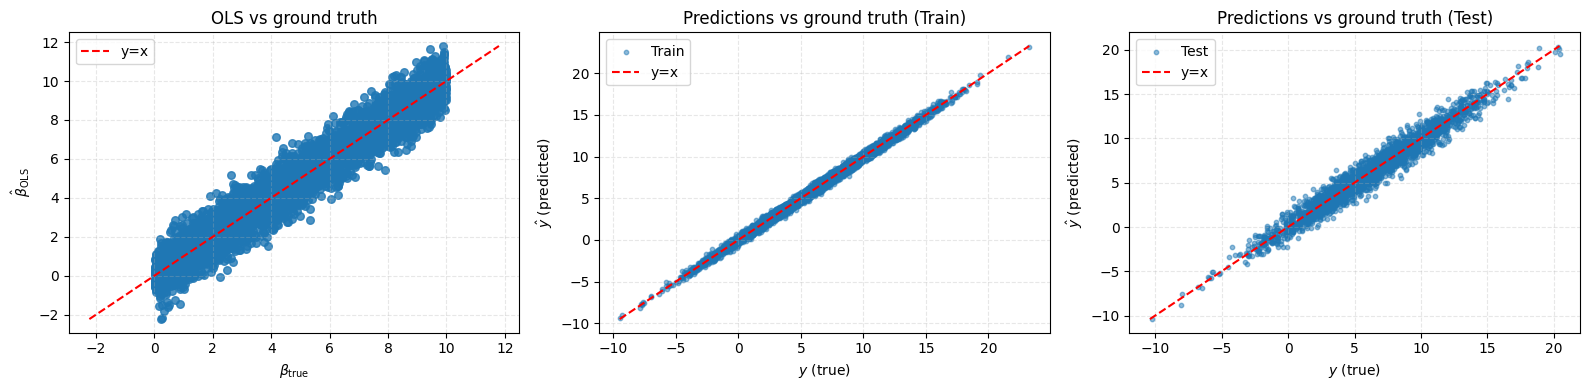

In [5]:
# Generate data and compare OLS coefficients to ground truth
rng = np.random.default_rng(7)
P, N = 5000, 10000
X_tr, X_te, y_tr, y_te, beta_true = generate_synthetic_linear_data(P, N, test_size=0.25, rng=rng)
print(f"X_tr shape: {X_tr.shape}")
print(f"X_te shape: {X_te.shape}")
print(f"y_tr shape: {y_tr.shape}")
print(f"y_te shape: {y_te.shape}")
print(f"beta_true shape: {beta_true.shape}")

# Fit OLS using the OLSClosedForm class
ols = OLSClosedForm()
ols.fit(X_tr, y_tr)
beta_hat = ols.coef_

# Basic metrics
abs_diff = np.abs(beta_hat - beta_true)
rel_err = np.linalg.norm(beta_hat - beta_true) / (np.linalg.norm(beta_true) + 1e-12)
print("beta_true:", np.round(beta_true, 3))
print("beta_hat:", np.round(beta_hat, 3))
print("abs diff:", np.round(abs_diff, 3))
print(f"relative error: {rel_err:.3e}")

# Predictions
y_hat_tr = ols.predict(X_tr)
y_hat_te = ols.predict(X_te)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1: beta_true vs beta_hat
ax = axes[0]
ax.scatter(beta_true, beta_hat, s=30, alpha=0.8)
minv = min(np.min(beta_true), np.min(beta_hat))
maxv = max(np.max(beta_true), np.max(beta_hat))
ax.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1.5, label="y=x")
ax.set_xlabel(r"$\beta_{\mathrm{true}}$")
ax.set_ylabel(r"$\hat{\beta}_{\mathrm{OLS}}$")
ax.set_title("OLS vs ground truth")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

# Plot 2: y vs y_hat (Training)
ax = axes[1]
ax.scatter(y_tr, y_hat_tr, s=10, alpha=0.5, label="Train")
minv = min(np.min(y_tr), np.min(y_hat_tr))
maxv = max(np.max(y_tr), np.max(y_hat_tr))
ax.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1.5, label="y=x")
ax.set_xlabel(r"$y$ (true)")
ax.set_ylabel(r"$\hat{y}$ (predicted)")
ax.set_title("Predictions vs ground truth (Train)")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

# Plot 3: y vs y_hat (Test)
ax = axes[2]
ax.scatter(y_te, y_hat_te, s=10, alpha=0.5, label="Test")
minv = min(np.min(y_te), np.min(y_hat_te))
maxv = max(np.max(y_te), np.max(y_hat_te))
ax.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1.5, label="y=x")
ax.set_xlabel(r"$y$ (true)")
ax.set_ylabel(r"$\hat{y}$ (predicted)")
ax.set_title("Predictions vs ground truth (Test)")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# TODO: Write a few comments on what you observe in your plots. For example, are $\beta_{\text{true}}$ and $\hat{\beta}_{\text{OLS}}$ close to each other? How about the predictions $y$ and $\hat{y}$? How does the prediction performance compare between the training and testing sets?

# Part 2: Implement the Evaluation Metrics

So far we have been relying on the visualizations to understand the performance of our model. In this part, we will implement the evaluation metrics to *quantitatively* evaluate the performance of our model.

Let $y_{\text{true}} \in \mathbb{R}^n$ be the observed responses and let $y_{\text{pred}}\in\mathbb{R}^n$ be the model predictions. In linear regression with fitted coefficients $\hat{\beta}$ and design matrix $X\in\mathbb{R}^{n\times p}$, we have the linear relationship $\hat{y} \equiv y_{\text{pred}} = X\hat{\beta}$ (i.e., $\hat{y}_i = x_i^\top\hat{\beta}$).

We will implement two metrics:
- RMSE: $\operatorname{RMSE}(y_{\text{true}}, y_{\text{pred}}) = \sqrt{\tfrac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$.
- R$^2$: $R^2(y_{\text{true}}, y_{\text{pred}}) = 1 - \dfrac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}$, where $\bar{y}=\tfrac{1}{n}\sum_i y_i$.

In [ ]:
def RMSE(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute root mean squared error (RMSE).

    Parameters
    ----------
    y_true : ndarray of shape (n_samples,)
        Ground-truth responses.
    y_pred : ndarray of shape (n_samples,)
        Predicted responses.

    Returns
    -------
    float
        The RMSE between `y_true` and `y_pred`.
    """
    # TODO: implement the RMSE using array operations.
    raise NotImplementedError("TODO: implement RMSE")

def R2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute the coefficient of determination R^2.

    Parameters
    ----------
    y_true : ndarray of shape (n_samples,)
        Ground-truth responses.
    y_pred : ndarray of shape (n_samples,)
        Predicted responses.

    Returns
    -------
    float
        R^2 in [-inf, 1]. A value of 1 indicates perfect predictions.

    Notes
    -----
    If `y_true` is constant (zero variance), the denominator is 0 and R^2 is
    undefined.
    """
    # TODO: implement the R2 using array operations.
    raise NotImplementedError("TODO: implement R2")

In [7]:
# Evaluate the OLS regressor on training and testing sets
train_rmse = RMSE(y_tr, y_hat_tr)
train_r2 = R2(y_tr, y_hat_tr)
test_rmse = RMSE(y_te, y_hat_te)
test_r2 = R2(y_te, y_hat_te)

print("OLS Regression Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R²:   {train_r2:.4f}")
print(f"Test RMSE:     {test_rmse:.4f}")
print(f"Test R²:       {test_r2:.4f}")

OLS Regression Performance:
Training RMSE: 0.2964
Training R²:   0.9947
Test RMSE:     0.8681
Test R²:       0.9560


# TODO: Write a few comments on what you observe in the RMSE and $R^2$ values. How does the performance compare between the training and testing sets?

# Part 3: Implement the Ridge Regression (the Regularized OLS Regression)

### Overfitting and why regularization helps

Overfitting happens when a model fits noise/idiosyncrasies in the training data rather than the underlying signal. In OLS, this is common when the feature dimension ($p$) is large relative to the sample size ($n$), or when features are highly correlated. Symptoms include near-zero training error but poor generalization: the model achieves high training set performance but poor test set performance.

Regularization adds a constraint or penalty that discourages overly complex solutions, trading a small amount of bias for a large variance reduction:
- L2 (ridge): shrinks coefficients toward zero, stabilizes the solution when $X^\top X$ is ill-conditioned, and improves generalization.
- L1 (lasso): promotes sparsity (feature selection) by driving some coefficients exactly to zero.

The net effect is lower variance, better-conditioned optimization, and typically improved test performance, especially in high-dimensional or noisy settings.

### Ridge Regression

Ridge regression adds an $\ell_2$ penalty to stabilize the solution by shrinking coefficients toward zero. Note that because the first column of $X$ is all ones and the first coefficient in $\beta$ is the intercept, we do not penalize it:

$$
\min_{w=(w_1,w_2,\ldots,w_p)}\; \tfrac{1}{2}\,\lVert y - Xw \rVert_2^2 + \tfrac{\lambda}{2}\,\lVert \Gamma w \rVert_2^2 = \min_{w}\; \tfrac{1}{2}\,\lVert y - Xw \rVert_2^2 + \tfrac{\lambda}{2}\,\lVert [w_2, \ldots, w_p] \rVert_2^2,\quad \Gamma = \mathrm{diag}(0,1,\ldots,1).
$$

Explicitly, for $p$ columns in $X$ (the first is ones),
$$
\Gamma \,=\, \begin{bmatrix}
0 & 0 & \cdots & 0 \\
0 & 1 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 1
\end{bmatrix} \in \mathbb{R}^{p\times p}.
$$

The first order condition yields the normal equations
$$
\left(X^\top X + \lambda\,\Gamma\right)\,\hat{\beta}_{\text{ridge}\,\lambda} = X^\top y,\quad\Rightarrow\quad 
\boxed{\;\hat{\beta}_{\text{ridge}\,\lambda} = \left(X^\top X + \lambda\,\Gamma\right)^{-1} X^\top y\;}
$$
- **Effect of $\lambda$**: As $\lambda \to 0$, ridge approaches OLS; as $\lambda$ increases, coefficients shrink and variance decreases (with some bias introduced). With a larger $\lambda$ (i.e., stronger regularization), the coefficients are more biased but the model is more stable and generalizes better.
- **Intercept**: We set the left-top entry of $\Gamma$ to 0 so the intercept is unpenalized.

### Optional: Derivation via gradient and first order condition

Start from the ridge objective with $\Gamma=\mathrm{diag}(0,1,\dots,1)$ (no penalty on intercept):
$$
J(w) = \tfrac{1}{2}\,\lVert y - Xw \rVert_2^2 + \tfrac{\lambda}{2}\,\lVert \Gamma w \rVert_2^2.
$$
Expand the gradient using $\nabla_w\,\tfrac{1}{2}\lVert y - Xw\rVert_2^2 = -X^\top(y - Xw)$ and $\nabla_w\,\tfrac{1}{2}\lVert\Gamma w\rVert_2^2 = \Gamma^\top\Gamma w$:
$$
\nabla_w J(w) = -X^\top(y - Xw) + \lambda\,\Gamma^\top\Gamma\,w
= (X^\top X + \lambda\,\Gamma)\,w - X^\top y.
$$
Setting $\nabla_w J(w)=0$ yields the normal equations
$$
(X^\top X + \lambda\,\Gamma)\,\hat{w} = X^\top y,
$$
which (when the matrix is invertible) gives the closed form
$$
\hat{w} = (X^\top X + \lambda\,\Gamma)^{-1} X^\top y.
$$
If $(X^\top X + \lambda\,\Gamma)$ is singular or poorly conditioned, use a numerically stable solver or the pseudoinverse.

In [ ]:
class RidgeClosedForm:
    """Ridge regression solved in closed form with an unpenalized intercept.

    Attributes
    ----------
    coef_ : ndarray of shape (n_features,)
        Fitted coefficients after calling `fit`.
    """
    def __init__(self) -> None:
        self.coef_ = None

    def fit(self, X: np.ndarray, y: np.ndarray, lambda_: float = 1.0) -> None:
        """
        Closed-form ridge regression with no penalty on the intercept.

        Solves (X^T X + lambda_ * Gamma) w = X^T y, where Gamma = diag(0, 1, ..., 1).

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Design matrix. The first column should be ones for the intercept.
        y : ndarray of shape (n_samples,)
            Response vector.
        lambda_ : float, default=1.0
            Nonnegative regularization strength.

        Returns
        -------
        None

        Raises
        ------
        numpy.linalg.LinAlgError
            If the system matrix is singular or ill-conditioned.

        Notes
        -----
        - The intercept (first coefficient) is unpenalized via Gamma[0, 0] = 0.
        - For lambda_ = 0, this reduces to OLS.
        """
        # ==============================================================================================================
        # TODO: implement the closed-form ridge regression solution for beta_hat using matrix operations.
        # Hint: build Gamma with Gamma[0,0]=0, then solve (X^T X + lambda_*Gamma) w = X^T y.
        # ==============================================================================================================
        raise NotImplementedError("TODO: implement RidgeClosedForm.fit")
        self.coef_ = ...

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict responses for X using the fitted ridge coefficients.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)

        Raises
        ------
        ValueError
            If the model has not been fit yet.
        """
        if self.coef_ is None:
            raise ValueError("Model not fit yet.")
        # ==============================================================================================================
        # TODO: implement the prediction using matrix operations.
        # ==============================================================================================================
        raise NotImplementedError("TODO: implement RidgeClosedForm.predict")
        return ...


## Ridge coefficient paths and train/test performance (you do not need to adjust the code here)

Fit ridge for a grid of $\lambda$ (including $\lambda=0$ for OLS), visualize coefficient paths, and report train/test $R^2$. We deliberately work in a high-dimensional regime (many parameters/features relative to the number of observations), where OLS can be unstable and prone to overfitting.

What to expect as $\lambda$ increases if your implementation is correct:

- Coefficients shrink smoothly toward 0 (intercept unpenalized), reflecting stronger regularization.
- Training performance typically degrades monotonically (higher RMSE, lower $R^2$) as bias increases.
- Test performance often improves from $\lambda=0$ up to a moderate $\lambda$ (variance reduction), then degrades again for very large $\lambda$ (underfitting). Test RMSE/$R^2$ vs $\lambda$ often looks U-shaped.

lambda= 10.0: RMSE_train=4.730  R2_train=0.165  RMSE_test=4.576  R2_test=0.031


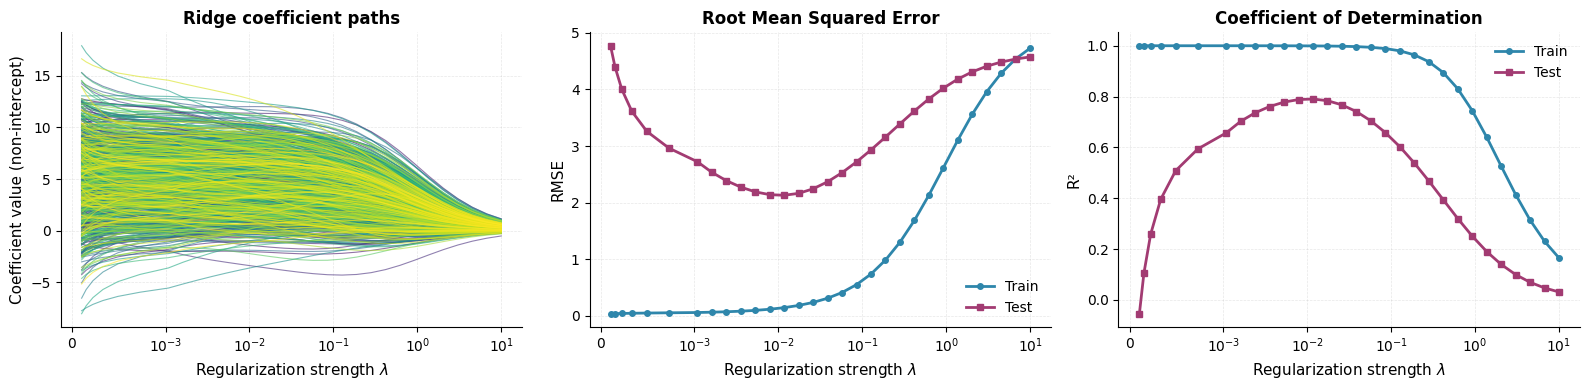

In [9]:
# Ridge coefficient paths exercise
rng = np.random.default_rng(123)
P, N = 750, 1000
X_tr, X_te, y_tr, y_te, beta_true = generate_synthetic_linear_data(P, N, test_size=0.25, rng=rng)

# Include lambda=0 (OLS) and positive lambdas for ridge; use symlog scale for plotting zeros
lambdas = np.logspace(-4, 1, 30)
coefs = []
train_rmses = []
train_r2s = []
test_rmses = []
test_r2s = []

rid = RidgeClosedForm()
for lam in lambdas:
    rid.fit(X_tr, y_tr, lambda_=lam)
    coefs.append(rid.coef_.copy())

    yhat_tr = rid.predict(X_tr)
    yhat_te = rid.predict(X_te)
    train_rmses.append(RMSE(y_tr, yhat_tr))
    train_r2s.append(R2(y_tr, yhat_tr))
    test_rmses.append(RMSE(y_te, yhat_te))
    test_r2s.append(R2(y_te, yhat_te))

# Print metrics for selected lambdas
for lam, train_rmse, train_r2, test_rmse, test_r2 in zip(lambdas, train_rmses, train_r2s, test_rmses, test_r2s):
    if lam in [0.0, 0.1, 1.0, 10.0]:
        print(f"lambda={lam:>5}: RMSE_train={train_rmse:.3f}  R2_train={train_r2:.3f}  RMSE_test={test_rmse:.3f}  R2_test={test_r2:.3f}")

# Plot coefficient paths, RMSE, and R2
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Coefficient paths (exclude intercept at index 0)
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, P))
feature_indices = range(1, P + 1)
for jj, j in enumerate(feature_indices):
    axes[0].plot(lambdas, [c[j] for c in coefs], lw=0.8, alpha=0.6, color=colors[jj])
axes[0].set_xscale('symlog', linthresh=1e-3)
axes[0].set_xlabel(r'Regularization strength $\lambda$', fontsize=11)
axes[0].set_ylabel('Coefficient value (non-intercept)', fontsize=11)
axes[0].set_title('Ridge coefficient paths', fontsize=12, fontweight='semibold')
axes[0].grid(True, linestyle='--', alpha=0.3, linewidth=0.5)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# RMSE vs lambda
axes[1].plot(lambdas, train_rmses, marker='o', markersize=4, lw=2, label='Train', color='#2E86AB')
axes[1].plot(lambdas, test_rmses, marker='s', markersize=4, lw=2, label='Test', color='#A23B72')
axes[1].set_xscale('symlog', linthresh=1e-3)
axes[1].set_xlabel(r'Regularization strength $\lambda$', fontsize=11)
axes[1].set_ylabel('RMSE', fontsize=11)
axes[1].set_title('Root Mean Squared Error', fontsize=12, fontweight='semibold')
axes[1].grid(True, linestyle='--', alpha=0.3, linewidth=0.5)
axes[1].legend(frameon=False, fontsize=10)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# R2 vs lambda
axes[2].plot(lambdas, train_r2s, marker='o', markersize=4, lw=2, label='Train', color='#2E86AB')
axes[2].plot(lambdas, test_r2s, marker='s', markersize=4, lw=2, label='Test', color='#A23B72')
axes[2].set_xscale('symlog', linthresh=1e-3)
axes[2].set_xlabel(r'Regularization strength $\lambda$', fontsize=11)
axes[2].set_ylabel('R²', fontsize=11)
axes[2].set_title('Coefficient of Determination', fontsize=12, fontweight='semibold')
axes[2].grid(True, linestyle='--', alpha=0.3, linewidth=0.5)
axes[2].legend(frameon=False, fontsize=10)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# TODO: write a few comments on what you observe as we increase the regularization strength $\lambda$. For example, you can comment how the magnitude of the coefficients evolve, how the RMSE and $R^2$ values on the training and testing sets change. How does the regularization affect the coefficients and the model's performance? How would you choose the best model configuration when the model is used for actual real-world prediction?

# You have completed all the parts of this homework. Congratulations!